## 1. Download dei dati ##

In [1]:
# Download dataset
#!wget https://www.zemris.fer.hr/projects/LicensePlates/english/baza_slika.zip
# Unzip file zip
#!unzip -o -j baza_slika.zip "*.jpg" -d dataset

## 2. Preparazione dei dati ##

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from skimage.transform import rescale
from skimage.util import view_as_windows
from torch.utils.data import DataLoader, random_split

In [3]:
# Percorso alla cartella che contiene le immagini
datasetPath = "dataset"

# Lista per salvare le immagini caricate
imgList = []

# Scorrimento di tutti i file nella cartella
i = 0
for fileName in os.listdir(datasetPath):
    if fileName.lower().endswith(".jpg"):
        filePath = os.path.join(datasetPath, fileName)
        #img = np.array(Image.open(filePath))
        img = np.array(Image.open(filePath)).astype(np.float32) / 255.0
        img = rescale(img, (1/1.66, 1/1.66, 1)) # Passaggio da 640x480 a 386x289 
        imgList.append(img)
        #i += 1
        #if i == 250:
        #    break

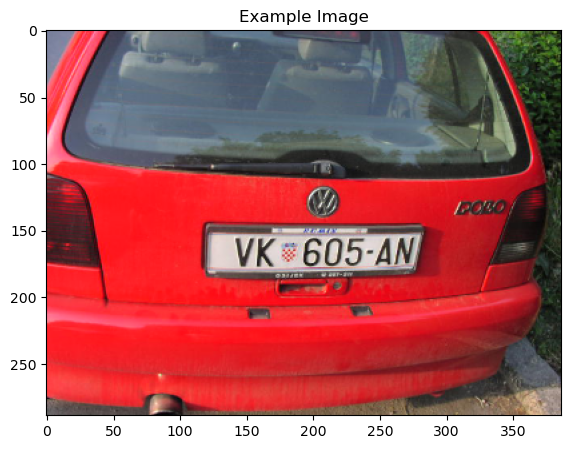

In [4]:
# Mostriamo un'immagine
randInd = np.random.randint(0,len(imgList))
plt.figure(figsize=(15,5))
plt.imshow(imgList[randInd])
plt.title('Example Image')
plt.show()

In [5]:
# Ridimensioniamo i blocchi
def resize_blocks(blocks, scaleY, scaleX):
    """
    Ridimensiona un insieme di blocchi in base a un fattore di scala 
    blocks: (n_rows, n_cols, h, w, 3)
    scaleY: fattore di scala sull'asse Y
    scaleX: fattore di scala sull'asse X
    """
    blocksRes = []
    for i in range(blocks.shape[0]):
        row = []
        for j in range(blocks.shape[1]):
            blockLow = rescale(blocks[i][j], (scaleY,scaleX,1))
            blockUp = rescale(blockLow, (1//scaleY, 1//scaleY, 1), order=1)
            row.append(blockUp)
        blocksRes.append(row)    
    return np.array(blocksRes)*255

# Ricostruiamo l'immagine con i nuovi blocchi
def reconstruct_img(blocks, stepY, stepX):
    """
    Ricostruisce un'immagine RGB da blocchi ridimensionati sovrapposti.
    Applica media nelle regioni sovrapposte.
    blocks: (n_rows, n_cols, h, w, 3)
    stepY: distanza verticale fra blocchi
    stepX: distanza orizzontale fra blocchi
    """
    nRows, nCols, h, w, c = blocks.shape
    H = (nRows - 1) * stepY + h
    W = (nCols - 1) * stepX + w
    canvas = np.zeros((H, W, c), dtype=np.float64)
    weight = np.zeros((H, W, c), dtype=np.float64)
    for i in range(nRows):
        for j in range(nCols):
            top = i * stepY
            left = j * stepX
            canvas[top:top+h, left:left+w, :] += blocks[i, j]
            weight[top:top+h, left:left+w, :] += 1
    return (canvas / np.maximum(weight, 1)).astype(np.uint8)

def downscale_data(img, windowShape, scale, step):
    blocks = view_as_windows(img, windowShape, step).squeeze()
    blocksLow = resize_blocks(blocks, scale, scale)
    imgLow = reconstruct_img(blocksLow, step, step)
    return imgLow

In [6]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms
import numpy as np

class ImgListDataset(Dataset):
    def __init__(self, imgList):
        self.imgList = imgList
        self.target_size = (289, 386)  # Altezza, larghezza desiderata
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.target_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgList)

    def __getitem__(self, idx):
        img = self.imgList[idx]
        if isinstance(img, np.ndarray):
            img = self.transform(img)
        return img



In [7]:
# Divisione dell'intero dataset in training set, validation set e test set (Circa 80%, 10% e 10%)
trainSet, valSet, testSet = random_split(imgList, [0.8, 0.1, 0.1])

windowShape = (96,96,3)
scale = 0.5
step = 24

# Creazione dei dataset di immagini ricostruite (downscale-upscale)
trainSetRic = []
valSetRic = []
testSetRic = []

for el in trainSet:
    imgLow = downscale_data(el, windowShape, scale, step)
    trainSetRic.append(imgLow)

for el in valSet:
    imgLow = downscale_data(el, windowShape, scale, step)
    valSetRic.append(imgLow)

for el in testSet:
    imgLow = downscale_data(el, windowShape, scale, step)
    testSetRic.append(imgLow)

In [8]:
# Creazione dei DataLoader per i set
batchSize = 6
numWorkers = 4

# Dataloader per le immagini originali
trainSetDataset = ImgListDataset(trainSet)
valSetDataset = ImgListDataset(valSet)
testSetDataset = ImgListDataset(testSet)

#TODO Controllare bene se usare shuffle=True
trainDataload = DataLoader(trainSetDataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
valDataload = DataLoader(valSetDataset, batch_size=batchSize, num_workers=numWorkers)
testDataload = DataLoader(testSetDataset, batch_size=batchSize, num_workers=numWorkers)

# Dataloader per le immagini originali
trainSetRicDataset = ImgListDataset(trainSetRic)
valSetRicDataset = ImgListDataset(valSetRic)
testSetRicDataset = ImgListDataset(testSetRic)

trainDataloadRic = DataLoader(trainSetRicDataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
valDataloadRic = DataLoader(valSetRicDataset, batch_size=batchSize, num_workers=numWorkers)
testDataloadRic = DataLoader(testSetRicDataset, batch_size=batchSize, num_workers=numWorkers)

print("Effettuata suddivisione:")
print(f"- Training-set: {len(trainSet)} campioni.")
print(f"- Validation-set: {len(valSet)} campioni.")
print(f"- Test-set: {len(testSet)} campioni.")
print(f"- Training-set Ric: {len(trainSetRic)} campioni.")
print(f"- Validation-set Ric: {len(valSetRic)} campioni.")
print(f"- Test-set Ric: {len(testSetRic)} campioni.")

Effettuata suddivisione:
- Training-set: 403 campioni.
- Validation-set: 50 campioni.
- Test-set: 50 campioni.
- Training-set Ric: 403 campioni.
- Validation-set Ric: 50 campioni.
- Test-set Ric: 50 campioni.


## 3. Architettura ##

In [9]:
import torch
import torch.nn as nn

class DnCNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, kernel_size=3, padding=1):
        super(DnCNN, self).__init__()
        layers = []
            # Primo blocco convoluzionale
            # in_channel = 3 poichè 3 canali
            # out_channel = 64 come scritto nella traccia (num feat)
            # kernel_size = 3 come scritto nella traccia (dim spaziale)
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
        layers.append(nn.ReLU())

        for i in range(14):
            layers.append(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
            layers.append(nn.BatchNorm2d(out_channels))                    # Corrisponde al numero di canali di output del livello precedente
            layers.append(nn.ReLU())

        layers.append(nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=kernel_size, padding=padding))

        # *layers corrisponde a layers[0],layers[1],..., quindi già spalmati come singoli elementi
        self.features = nn.Sequential(*layers)

        self.apply(self.kernel_initializer)

    def forward(self, x):
        return self.features(x)
    
    # Equivalente a kernel_inizializer="Orthogonal" in pytorch
    def kernel_initializer(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
        elif isinstance(module, nn.Conv2d):
            nn.init.orthogonal_(module.weight)


## 4. Addestramento ##

In [10]:
# Librerie
import time

In [11]:
# Abilitiamo il dispositivo GPU per il training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
# Criterion deve essere torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
# Legenda dataloader:
#   - dlTrain = immagini originali training
#   - dlTrainRic = immagini ricostruite (downscalate-upscalate) training
#   - dlVal = immagini originali validation
#   - dlValRic = immagini ricostruite (downscalate-upscalate) validation


def training (dlTrain, dlTrainRic, dlVal, dlValRic, numEpoch, model, criterion, optimizer, bestMse, bestPsnr, bestEpoch, outputPath):
    
    # Iterazione per ogni epoch
    for epoch in range(numEpoch):
        
        model.cuda()
        # Conteggio del tempo per misurare la durata di un'epoca
        since = time.time()

        # Inizializzazione delle variabili
        modelMseTrain = 0.0
        totalSize = 0


        # Modello impostato in traning mode
        model.train()

        # Iterazione per ogni batch
        # Devo iterare su i 2 dataloader contemporaneamente, per fare ciò utilizzo zip
        for (inputsTrain, inputsRic) in zip(dlTrain, dlTrainRic):


            # Converto gli input in tensori float e li carico nella GPU
            inputsTrain = inputsTrain.type(torch.FloatTensor).cuda()
            inputsRic = inputsRic.type(torch.FloatTensor).cuda()

            # Reset dei gradienti, altrimenti i vecchi gradienti sono sommati ai nuovi, piuttosto 
            # che essere sovrascritti
            optimizer.zero_grad()
            model.zero_grad()

            # Calcolo dettagli e ricostruzione immagine
            yTrain = model(inputsRic)
            y = yTrain + inputsRic

            # Calcolo della MSE
            loss = criterion(y, inputsTrain)   
            # size(0) restituisce il numero di campioni nel batch, quindi si sta moltiplicando la loss 
            # media per il numero di elementi per ottenere la somma totale della loss          
            modelMseTrain += loss.item() * inputsTrain.size(0)
            totalSize += inputsTrain.size(0)
            
            # Calcolando il gradiente del tensore attuale
            loss.backward()
            # Esecuzione di un singolo step di ottimizzazione in modo tale da aggiornare i pesi
            optimizer.step()

            del loss

        # Calcolo della MSE medio e del PSNR medio  dell'epoch
        modelMseEpochTrain = modelMseTrain/totalSize
        modelPsnrEpochTrain = 10 * torch.log10(torch.tensor(255 ** 2 / modelMseEpochTrain))

        # Salvataggio dei pesi per ogni iterazione
        # torch.save(model.state_dict(), outputPath + "train_weights.pth")

        # Modello impostato in validation mode
        model.eval()

        # Inizializzazione delle variabili
        modelMseVal = 0.0
        totalSizeVal = 0

        with torch.no_grad():               # Disattiva il calcolo dei gradienti
        # Iterazione per ogni bach
        # Devo iterare su i 2 dataloader contemporaneamente, per fare ciò utilizzo zip
            for (inputsVal, inputsValRic) in zip(dlVal, dlValRic):
                
                # Converto gli input in tensori float e li carico nella GPU
                inputsVal = inputsVal.type(torch.FloatTensor).cuda()
                inputsValRic = inputsValRic.type(torch.FloatTensor).cuda()

                # Calcolo dettagli
                yVal = model(inputsValRic)
                y = yVal + inputsValRic

                # Calcolo della MSE
                loss = criterion(y, inputsVal)   
                # size(0) restituisce il numero di campioni nel batch, quindi si sta moltiplicando la loss 
                # media per il numero di elementi per ottenere la somma totale della loss          
                modelMseVal += loss.item() * inputsVal.size(0)
                totalSizeVal += inputsVal.size(0)
            
            # Calcolo della MSE medio e del PSNR medio  dell'epoch
            modelMseEpochVal = modelMseVal/totalSizeVal
            modelPsnrEpochVal = 10 * torch.log10(torch.tensor(255 ** 2 / modelMseEpochVal))
            timeElapsed = time.time()-since

        print('[Epoch %d][Train on %d [MSE: %.4f  PSNR: %.4f]][Val on %d [MSE: %.4f  PSNR: %.4f]][Time: %.0f m %.0f s]'
                %(epoch, totalSize, modelMseEpochTrain, modelPsnrEpochTrain, totalSizeVal, modelMseEpochVal,
                modelPsnrEpochVal, timeElapsed // 60, timeElapsed % 60))        

        # Salvaggio dei risultati migliori
        if (modelMseEpochVal < bestMse):
            print("-------Saving best weights-------")
            bestMse = modelMseEpochVal
            bestPsnr = modelPsnrEpochVal
            bestEpoch = epoch
            # Salvataggio dei migliori risultati
            try:
                torch.save(model.cpu().state_dict(), outputPath)
                print("-------Best weights saved-------")
            except Exception as e:
                print("Error:", e)


        # Salvataggio dei risultati per ogni epoch in modo da utilizzarli in seguito per la visualizzazione
        with open(outputPath + "MSETrain.txt", "a") as file_object:
            file_object.write(str(modelMseEpochTrain) + "\n")

        with open(outputPath + "PSNRTrain.txt", "a") as file_object:
            file_object.write(str(modelPsnrEpochTrain) + "\n")
        
        with open(outputPath + "MSEVal.txt", "a") as file_object:
            file_object.write(str(modelMseEpochVal) + "\n")

        with open(outputPath + "PSNRVal.txt", "a") as file_object:
            file_object.write(str(modelPsnrEpochVal) + "\n")
        
        
    return bestMse, bestPsnr
            



In [13]:
# Funzione di testing

def testing (dlTest, dlTestRic, model, criterion, weightPath):
    
    # Caricamento dei pesi
    model.load_state_dict(torch.load(weightPath, map_location=torch.device("cpu")))
    model.cuda()


    # Conteggio del tempo per misurare la durata di un'epoca
    since = time.time()

    # Inizializzazione delle variabili
    modelMseTest = 0.0
    totalSize = 0


    #model.load_state_dict(torch.load(weightPath , map_location=device))
    model.eval()

    # Iterazione su batch
    with torch.no_grad():               # Disattiva il calcolo dei gradienti
        for (inputsTest, inputsTestRic) in zip(dlTest, dlTestRic):
    

            # Converto gli input in tensori float e li carico nella GPU
            inputsTest = inputsTest.type(torch.FloatTensor).cuda()
            inputsTestRic = inputsTestRic.type(torch.FloatTensor).cuda()
            
            # Calcolo dettagli e ricostruzione immagine
            yTest = model(inputsTestRic)
            y = yTest + inputsTestRic

            # Calcolo della MSE
            loss = criterion(y, inputsTest)
            # size(0) restituisce il numero di campioni nel batch, quindi si sta moltiplicando la loss 
            # media per il numero di elementi per ottenere la somma totale della loss   
            modelMseTest += loss.item() * inputsTest.size(0)
            totalSize += inputsTest.size(0)


        # Calcolo della MSE medio e del PSNR medio  dell'epoch
        modelMseEpochTest = modelMseTest/totalSize
        modelPsnrEpochTest = 10 * torch.log10(torch.tensor(255 ** 2 / modelMseEpochTest))
        timeElapsed = time.time()-since

        print("[Test] [MSE: %.4f  PSNR: %.4f] [Time: %.0f m %.0f s]"
          %(modelMseEpochTest, modelPsnrEpochTest, timeElapsed // 60, timeElapsed % 60))

## 5. Valutazione delle prestazioni ##

In [14]:
def graphVisualization():
  # Liste per memorizzare MSE e PNSR di training e validation
  MseModelTrain = []
  MseModelVal = []
  PSNRModelTrain = []
  PSNRModelVal = []

  # Apertura del file
  file = open("MSETrain.txt", "r")
  text = file.readlines()
  # Salvataggio di ogni elemento del file testo nella lista
  for el in text:
    MseModelTrain.append(float(el))

  # Apertura del file
  file = open("MSEVal.txt", "r")
  text = file.readlines()
  # Salvataggio di ogni elemento del file testo nella lista
  for el in text:
    MseModelVal.append(float(el))

  # Creation of the losses graph
  plt.figure()
  plt.title("Model: Training Vs Validation Losses")
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.plot(list(range(1,len(MseModelTrain)+1)), MseModelTrain, color="r", label="Training MSE")
  plt.plot(list(range(1, len(MseModelVal)+1)), MseModelVal, color="b", label="Validation MSE")
  plt.legend()

  # Apertura del file
  file = open("PSNRTrain.txt", "r")
  text = file.readlines()
  # Salvataggio di ogni elemento del file testo nella lista
  for el in text:
    PSNRModelTrain.append(float(el))

  # Apertura del file
  file = open("PSNRVal.txt", "r")
  text = file.readlines()
  # Salvataggio di ogni elemento del file testo nella lista
  for el in text:
    PSNRModelVal.append(float(el))

  # Creating the accuracy graph
  plt.figure()
  plt.title("Training Vs Validation Accuracies")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(list(range(1, len(PSNRModelTrain)+1)), PSNRModelTrain, color="r", label="Training PSNR")
  plt.plot(list(range(1, len(PSNRModelVal)+1)), PSNRModelVal, color="b", label="Validation PSNR")
  plt.legend()


In [15]:
# Iper parametri
#learningRate = 0.0001
numEpoch = 2
learningRateList = [0.01, 0.001, 0.0001]

In [19]:
# Main
import torch.optim as optim

model = DnCNN().cuda()
criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

bestMSELr = 9000000000000000000.0              # Miglior MSE tra tutti i learning rate
bestPSNRLr = -900000000000000000.0             # Miglior PSNR tra tutti i learning rate

weightPath = "best_weights.pth"
weightPathLr = "best_weights_lr.pth"

for lr in learningRateList:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    bestMse = 9000000000000000000.0             # Miglior MSE del singolo learning rate
    bestPsnr = -900000000000000000.0            # Miglior PSNR del singolo learning rate
    bestEpoch = 0

    bestMSES, bestPSNRS = training (trainDataload, trainDataloadRic, valDataload, valDataloadRic, numEpoch, model, criterion, optimizer, bestMse, bestPsnr, bestEpoch, weightPath)

    # Aggiorno i valori di miglior MSE
    if bestMSES < bestMSELr:
        bestMSELr = bestMSES
        bestPSNRLr = bestPSNRS
        # Caricamento dei pesi
        torch.save(model.cpu().state_dict(), weightPathLr)
        print("------Best LR saved-------")
        model.cuda()
    
print(f"MSE: {bestMSELr}")
print(f"PSNR: {bestPSNRS}")



[Epoch 0][Train on 403 [MSE: 0.1996  PSNR: 55.1294]][Val on 50 [MSE: 0.0432  PSNR: 61.7787]][Time: 0 m 40 s]
-------Saving best weights-------
-------Best weights saved-------
[Epoch 1][Train on 403 [MSE: 0.0719  PSNR: 59.5646]][Val on 50 [MSE: 0.0325  PSNR: 63.0114]][Time: 0 m 40 s]
-------Saving best weights-------
-------Best weights saved-------
------Best LR saved-------
[Epoch 0][Train on 403 [MSE: 0.0699  PSNR: 59.6836]][Val on 50 [MSE: 0.0391  PSNR: 62.2134]][Time: 0 m 40 s]
-------Saving best weights-------
-------Best weights saved-------
[Epoch 1][Train on 403 [MSE: 0.0690  PSNR: 59.7453]][Val on 50 [MSE: 0.0502  PSNR: 61.1232]][Time: 0 m 40 s]
[Epoch 0][Train on 403 [MSE: 0.0668  PSNR: 59.8805]][Val on 50 [MSE: 0.0388  PSNR: 62.2433]][Time: 0 m 40 s]
-------Saving best weights-------
-------Best weights saved-------
[Epoch 1][Train on 403 [MSE: 0.0670  PSNR: 59.8680]][Val on 50 [MSE: 0.0435  PSNR: 61.7419]][Time: 0 m 40 s]
MSE: 0.03250419199466705
PSNR: 62.24327850341797


In [20]:
testing(testDataload, testDataloadRic, model, criterion, weightPathLr)

[Test] [MSE: 0.0330  PSNR: 62.9504] [Time: 0 m 2 s]
